In [82]:
import sys
import os
import random
import json
import gc
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score
from functools import partial
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from tensorflow import keras

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset


from torchvision import transforms

In [83]:
## Configurations
class CFG:
    resnext = 'resnext50_32x4d'
    deit = 'deit_base_patch16_384'
    efficientnet = 'tf_efficientnet_b4_ns' 
    n_class = 5
    trn_fold = [1,2,3,4,5]
    data_dir = './data/test_images'
    result_dir = './result'
    batch_size = 8
    deit = 'deit_base_patch16_384'
    img_size = (512,512)

In [84]:
image_size = (512,512)
submission = pd.DataFrame(columns={"image_id","label"})
submission["image_id"] = os.listdir(CFG.data_dir)
submission["label"] = 0

In [85]:
onlykeras = False
        
used_models_pytorch = {"efficientnet": [f'./checkpoint/Efficientnet/f{fold}.pth' for fold in CFG.trn_fold],
                       "resnext": [f'./checkpoint/Resnext50/f{fold}.pth' for fold in CFG.trn_fold],
                       "deit": [f'./checkpoint/Deit/f{fold}.pth' for fold in CFG.trn_fold]
                      }

used_models_keras = {"cropnet": "./checkpoint/Cropnet"}

# We used this flag for testing different ensembling approaches
stacked_mean = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [86]:
# util
def load(model_path, net):
    dict_model = torch.load(model_path)
    net.load_state_dict(dict_model)
    return net

ResNext50_32x4d

In [87]:
# dataset 클래스는 resnext와 deit 공통으로 사용할 수 있다.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform

        self.lst_input = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        input = cv2.imread(os.path.join(self.data_dir, self.lst_input[index]), cv2.IMREAD_COLOR)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)  # result of input shape is y,x,c
        print(input.shape)

        if self.transform:
            input = self.transform(image=input)['image']

        data = {'input' : input}

        return data

In [88]:
class resnext(nn.Module):
    def __init__(self, network=CFG.resnext, n_class=CFG.n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(network, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [89]:
if "resnext" in used_models_pytorch:
    def transform_test():
        return A.Compose([A.Resize(512, 512),
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()])

    def inference(models, loader_test, device):
        pred = [] 
        for batch, data in enumerate(loader_test, 1):
            input = data['input'].to(device)

            avg_output = []
            
            for model in models:
                model.eval()
                with torch.no_grad():
                    output = model(input)
                avg_output.append(output.softmax(1).to('cpu').numpy())
            avg_output = np.mean(avg_output, axis=0)
            pred.append(avg_output)
        return np.concatenate(pred) 
    
    
    # inference
    net = resnext(CFG.resnext, CFG.n_class, pretrained=False).to(device)  
    models = [load(f, net) for f in used_models_pytorch["resnext"]]
    dataset_test = Dataset(data_dir=CFG.data_dir, transform=transform_test())
    loader_test = DataLoader(dataset_test, batch_size=CFG.batch_size, shuffle=False, num_workers=8, pin_memory=True) 
    
    pred = inference(models, loader_test, device)

    # submission save
    predictions_resnext = pd.DataFrame(columns={"image_id"})
    predictions_resnext["image_id"] = submission["image_id"].values
    predictions_resnext['image_path_id'] = CFG.data_dir + predictions_resnext['image_id'].astype(str)

    predictions_resnext['resnext'] = [np.squeeze(p) for p in pred]
    predictions_resnext = predictions_resnext.drop(["image_path_id"], axis=1)
    

    # empty_cache() 를 통해 사용하지 않으면서 캐시된 메모리들을 해제할 수 있다.
    torch.cuda.empty_cache()
    try:
        del(model)
        del(states)
    except:
        pass
    gc.collect()

(600, 800, 3)


In [90]:
predictions_resnext

,image_id,resnext
0,2216849948.jpg,"[0.016739627, 0.009845901, 0.21215543, 0.01410..."


Deit

In [91]:
class deit(nn.Module):
    def __init__(self, network, n_class, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', network, pretrained=pretrained)
        # self.model = timm.create_model('vit_deit_base_patch16_384', pretrained=pretrained)
        self.n_features = self.model.head.in_features
        self.model.head = nn.Linear(self.n_features,n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [92]:
if "deit" in used_models_pytorch:    
    def transform_test():
        return A.Compose([A.CenterCrop(384, 384, p=1.),
                A.Resize(384, 384),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0)], p=1.)

    def inference(models, loader_test, device):
        pred = [] 
        for batch, data in enumerate(loader_test, 1):
            input = data['input'].to(device)
            avg_output = []            
            
            for model in models:
                model.eval()
                
                with torch.no_grad():
                    output = model(input)
                avg_output.append(output.softmax(1).to('cpu').numpy())
                
            avg_output = np.mean(avg_output, axis=0)
            pred.append(avg_output)
            
        return np.concatenate(pred)    
    
    # inference
    net = deit(CFG.deit, CFG.n_class, pretrained=False).to(device)   
    models = [load(f, net) for f in used_models_pytorch["deit"]]

    dataset_test = Dataset(data_dir=CFG.data_dir, transform=transform_test())
    loader_test = DataLoader(dataset_test, batch_size=CFG.batch_size, shuffle=False, num_workers=8, pin_memory=True) 
    pred = inference(models, loader_test, device)

    
    # submission save
    predictions_deit = pd.DataFrame(columns={"image_id"})
    predictions_deit["image_id"] = submission["image_id"].values
    predictions_deit['image_path_id'] = CFG.data_dir + predictions_deit['image_id'].astype(str)

    predictions_deit['deit'] = [np.squeeze(p) for p in pred]
    predictions_deit = predictions_deit.drop(["image_path_id"], axis=1)
    
    
    torch.cuda.empty_cache()
    try:
        for model in models:
            del(model)
    except:
        pass
    models = []
    gc.collect()

Using cache found in /home/kerrykim/.cache/torch/hub/facebookresearch_deit_main


(600, 800, 3)


In [93]:
predictions_deit

,image_id,deit
0,2216849948.jpg,"[0.025769398, 0.077960335, 0.43972144, 0.01591..."


Efficientnet

In [94]:
class efficientnet(nn.Module):
    def __init__(self, network, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(network, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [95]:
# 데이터 증강방식이 많이 달라서 efficientnet 전용 dataset 클래스가 필요하다.
class DatasetEff(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform

        self.lst_input = os.listdir(self.data_dir)       
        
    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        pil_input = Image.open(os.path.join(self.data_dir, self.lst_input[index])) # result.shape (512, 512, 3)
        input = self.augment_tiles_light(self.create_image_tiles(*self.read_preprocess_file(pil_input))) # result.shape (10, 512, 512, 3)
                      
        return input

    def read_preprocess_file(self, image, normalize=False):   # norm은 transform을 통해서 한다.
        if normalize:
            img_scaled = np.array(image)/ 255.0
        else:
            img_scaled = np.array(image)
        img_scaled = img_scaled.astype(np.float32)

        return (image.size[0], image.size[1]), img_scaled  


    def create_image_tiles(self, origin_dim, processed_img): 
        crop_size = 512
        img_list = []
        for x in [0, origin_dim[1] - crop_size]:
            for y in [0, origin_dim[0] - crop_size]:
                img_list.append(processed_img[x:x+crop_size , y:y+crop_size,:])
        img_list.append(cv2.resize(processed_img[:, 100:700 ,:], dsize=(crop_size, crop_size)))
        return np.array(img_list)


    def augment_tiles_light(self, tiles, ttas=2): 
        holdout = np.broadcast_to(tiles[-1,:,:,:],(ttas,) + tiles.shape[1:])       
        lst = np.concatenate([tiles[:-1,:,:,:] for _ in range(ttas)], axis=0)

        augmented_batch = np.array([self.transform(image=lst[i, :, :, :])['image'] for i in range(8)])      
        return np.concatenate([augmented_batch, holdout], axis=0) 

In [96]:
if "efficientnet" in used_models_pytorch:  
    def transform_test():
        return A.Compose([A.Resize(512, 512),
                          A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                          A.Transpose(p=0.75),
                          A.HorizontalFlip(p=0.75),
                          A.VerticalFlip(p=0.75),
                          A.RandomRotate90(p=0.75)])
    
    # ToTensor를 빼주는 이유는 센터 크롭만 뺀 나머지 타일에만 transform 함수가 적용되기 때문에
    # 센터 크롭 타일을 또 별개로 tensor화 시켜주는 과정이 너무 번거롭다.
    
    def inference(models, loader_test, device):
        
        # batch에 대한 for문
        pred = [] 
        for batch, input in enumerate(loader_test, 1): 
            # pytorch dataloader를 사용하면 무조건 차원이 하나 증가한 토치형태로 값이 나온다...
            # input shape를 dataset에서 [10, 512, 512, 3], np array로 만들었는데 [1, 10, 512, 512, 3], tensor로 나옴
            input = np.squeeze(input).to('cpu').detach().numpy() 
            
            # 폴드 모델애 대한 for 문 
            avg_output = []
            for i in range(10):
                # 각 타일들을 np array로 받았기 때문에 텐서로 바꿔주는 과정이 필요하다.
                one_tile = input[i, :, : ,:] # result.shape (512, 512, 3) // 차원이 축소된다.
                one_tile = np.moveaxis(one_tile[:, :, :], -1, 0) 
                one_tile = np.expand_dims(one_tile, 0)
                one_tile = torch.from_numpy(one_tile)
                one_tile = one_tile.to(device)


                with torch.no_grad():
                    
                    # 데이터 증강을 통해 tiles에 대한 for문
                    tta_output=[]
                    for model in models:
                        model.eval()
                        output = model(one_tile)
                        tta_output.append(output.softmax(1).to('cpu').numpy())
                
                tta_output = np.mean(tta_output, axis=0)
                avg_output.append(tta_output)
                
            avg_output = np.mean(avg_output, axis=0)
            pred.append(avg_output)
            
        return np.concatenate(pred)    
    
    # inference
    net = efficientnet(CFG.efficientnet, CFG.n_class, pretrained=False).to(device)   
    models = [load(f, net) for f in used_models_pytorch["efficientnet"]]

    dataset_test = DatasetEff(data_dir=CFG.data_dir, transform=transform_test())
    # 이미지를 한장씩 넣어서 증강시켜야 하므로 batch_size를 1로 고정시킨다.
    loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8, pin_memory=True) 
    
    # 아직 argmax를 하지 않았기 때문에 probability인 상태이다.
    pred = inference(models, loader_test, device)

    
    # submission save
    predictions_eff = pd.DataFrame(columns={"image_id"})
    predictions_eff["image_id"] = submission["image_id"].values
    predictions_eff['image_path_id'] = CFG.data_dir + predictions_eff['image_id'].astype(str)

    predictions_eff['efficientnet'] = [np.squeeze(p) for p in pred]
    predictions_eff = predictions_eff.drop(["image_path_id"], axis=1)
    
    
    torch.cuda.empty_cache()
    try:
        for model in models:
            del(model)
    except:
        pass
    models = []
    gc.collect()

In [97]:
image = next(iter(loader_test))
image.shape

torch.Size([1, 10, 512, 512, 3])

In [98]:
image = np.squeeze(image).to('cpu').detach().numpy() 
image.shape

(10, 512, 512, 3)

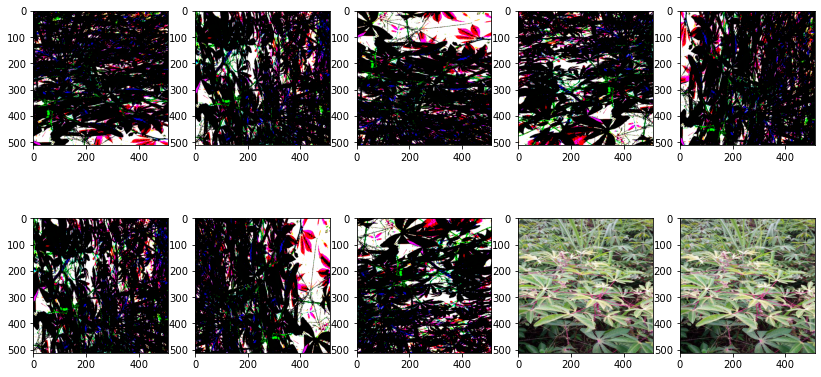

In [99]:
fig = plt.figure(figsize = (14, 7))
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.imshow((image[i, : , :, :]).astype(np.uint8)) # tlqkf 또 매직키워드, 0~1로 클립핑되는 건 plt 특징인 것같다. 유니트로 변환할것

plt.show()

In [100]:
predictions_eff

# 9번째 10번째 이미지에 대하여 값이 0,1로 나오는데 아마 학습때 테스트 이미지가 있었나봄

,image_id,efficientnet
0,2216849948.jpg,"[0.030135145, 0.038394645, 0.21901628, 0.22666..."


In [101]:
import tensorflow_hub as hub

In [102]:
os.environ["TFHUB_CACHE_DIR"] = "./"

In [103]:
def read_preprocess_file(img_path, normalize=False):
    image = Image.open(img_path)
    if normalize:
        img_scaled = np.array(image)/ 255.0
    else:
        img_scaled = np.array(image)
    img_scaled = img_scaled.astype(np.float32)
    print(image)
    return (image.size[0], image.size[1]), img_scaled 

In [104]:
def cut_crop_image(processed_img):
    image = tf.image.central_crop(processed_img, 0.8)
    image = tf.image.resize(image, (224, 224))
    return np.expand_dims(image, 0)    # 만약 np.expand_dims하지 않으면 TensorShape([224, 224, 3])의 shape가 나온다.

In [105]:
def build_mobilenet3(img_size=(224,224), weights="./checkpoint/Cropnet"):
    classifier = hub.KerasLayer(weights)
    model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=img_size + (3,)), # input shape= 224,224,3 
                                 hub.KerasLayer(classifier, trainable=False)])
    return model

In [106]:
def distribute_unknown(propabilities):
    return propabilities[:,:-1] + np.expand_dims(propabilities[:,-1]/5, 1) 

In [107]:
def multi_predict_tfhublayer(img_path, modelinstance):
    # 여기서 하단의 True는 normalize에 대한 인자로 normalize 하겠다는 의미
    img = cut_crop_image(read_preprocess_file(img_path, True)[1])
    yhat = modelinstance.predict(img)
    return np.mean(distribute_unknown(yhat), axis=0)

In [108]:
def predict_and_vote(image_list, modelinstances, onlykeras):
    predictions = [] 
    with tqdm(total=len(image_list)) as process_bar:       
        for img_path in image_list:
            process_bar.update(1)  
            Yhats = np.vstack([func(img_path, modelinstance) for func, modelinstance in modelinstances])
            print(Yhats)
        
        # onlykeras = False 해당구문 실행 안됨. 아마 결과값(predictions)은 확률값으로 나올듯 하긴 그래야 파이토치로 구현한 레즈넷등이랑 앙상블함
        if onlykeras:
            predictions.append(np.argmax(np.sum(Yhats, axis=0)))
        else:
            predictions.append(Yhats)    
    return predictions

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference_models = []

if "cropnet" in used_models_keras:   
    model_mobilenet = build_mobilenet3(weights=used_models_keras["cropnet"])    # 크롭넷 모델 정의
    inference_models.append((multi_predict_tfhublayer, model_mobilenet)) 

In [110]:
submission["label"] = predict_and_vote([os.path.join(CFG.data_dir, id) for id in submission["image_id"].values], inference_models, onlykeras)

  0%|          | 0/1 [00:00<?, ?it/s]

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7F26B2B5B810>


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

[[0.00399159 0.00370761 0.8709404  0.00654031 0.11482014]]


In [111]:
submission

,label,image_id
0,"[[0.0039915913, 0.0037076084, 0.8709404, 0.006...",2216849948.jpg


In [112]:
tf.keras.backend.clear_session()

try:
    del inference_models[:]
except:
    pass

gc.collect()

751

In [113]:
if len(list(used_models_keras.keys())) <= 1:    
    submission.loc[:,list(used_models_keras)[0]] = submission["label"].explode()
else:
    tmp = (submission['label'].transform([lambda x:x[0], lambda x:x[1]]).set_axis(list(used_models_keras.keys()), axis=1, inplace=False))
    submission = submission.merge(tmp, right_index=True, left_index=True)

In [114]:
submission

,label,image_id,cropnet
0,"[[0.0039915913, 0.0037076084, 0.8709404, 0.006...",2216849948.jpg,"[0.0039915913, 0.0037076084, 0.8709404, 0.0065..."


In [115]:
submission["label"] = 0

if "resnext" in used_models_pytorch:
    submission = submission.merge(predictions_resnext, on="image_id")
    
if "deit" in used_models_pytorch:
    submission = submission.merge(predictions_deit, on="image_id")
    
if "efficientnet" in used_models_pytorch:
    submission = submission.merge(predictions_eff, on="image_id")

In [116]:
submission

,label,image_id,cropnet,resnext,deit,efficientnet
0,0,2216849948.jpg,"[0.0039915913, 0.0037076084, 0.8709404, 0.0065...","[0.016739627, 0.009845901, 0.21215543, 0.01410...","[0.025769398, 0.077960335, 0.43972144, 0.01591...","[0.030135145, 0.038394645, 0.21901628, 0.22666..."


In [117]:
if stacked_mean:
    # zip 함수는 값을 받아 새로운 배열을 만든다. vit와 resnext를 받아서 e = (vit, resnext)이란 zip 데이터  타입을 만들어 평균함
    submission["stage_1"] = submission.apply(lambda x: [np.mean(e) for e in zip(x["deit"], x["resnext"])], axis=1)
    # stage1은 vit와 resnext를 평균취해서 새로운 확률을 만들고
    # stage1과 cropnet, efficientnet 값을 모두 더한후 argmax 취해서 가장 큰 값을 라벨로 얻는다.
    submission["label"] = submission.apply(lambda x: np.argmax(
        [np.sum(e) for e in zip(x["cropnet"],x["stage_1"], x["efficientnet"])]), axis=1)        
else:
    submission["label"] = submission.apply(lambda row: np.argmax(
        [np.sum(e) for e in zip(*[row[m] for m in list(used_models_pytorch.keys())+list(used_models_keras.keys())])]), axis=1)

In [118]:
submission.head(1)

,label,image_id,cropnet,resnext,deit,efficientnet,stage_1
0,2,2216849948.jpg,"[0.0039915913, 0.0037076084, 0.8709404, 0.0065...","[0.016739627, 0.009845901, 0.21215543, 0.01410...","[0.025769398, 0.077960335, 0.43972144, 0.01591...","[0.030135145, 0.038394645, 0.21901628, 0.22666...","[0.021254513, 0.04390312, 0.32593843, 0.015009..."


In [119]:
submission[["image_id","label"]].to_csv(os.path.join(CFG.result_dir,"submission.csv"), index=False)

In [120]:
!head ./result/submission.csv

image_id,label
2216849948.jpg,2


In [121]:
a = [[[1,2,3],[3,4,5], [5,6,7], [7,8,8]], [[2,2,2],[3,3,3], [5,6,7], [7,8,8]], [[2,2,2],[3,3,3], [5,6,7], [7,8,8]], [[2,2,2],[3,3,3], [5,6,7], [7,8,8]]]
b= np.array(a)
b.shape

(4, 4, 3)

In [122]:
for i in b:
    print(i)

[[1 2 3]
 [3 4 5]
 [5 6 7]
 [7 8 8]]
[[2 2 2]
 [3 3 3]
 [5 6 7]
 [7 8 8]]
[[2 2 2]
 [3 3 3]
 [5 6 7]
 [7 8 8]]
[[2 2 2]
 [3 3 3]
 [5 6 7]
 [7 8 8]]


In [123]:
print(b[1, :, :])

[[2 2 2]
 [3 3 3]
 [5 6 7]
 [7 8 8]]


In [124]:
c=b[0, :, :]
c

array([[1, 2, 3],
       [3, 4, 5],
       [5, 6, 7],
       [7, 8, 8]])

In [125]:
c.shape

(4, 3)

In [126]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
a.shape

(3, 4)

In [127]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11]])
a.shape

/home/kerrykim/anaconda3/envs/cldc/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(3,)